In [25]:
#|default_exp sgd

# Accelerated SGD

In [26]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [27]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [28]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(69)

In [29]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimizers

### SGD

In [31]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

- The `reg_step` method applies L2 regularization to a parameter `p`.
- L2 regularization adds a regularization term to the loss function to penalise large parameter values and is used to prevent overfitting.
- multiplication by `1 - self.lr * self.wd` shrinks the parameter `p` towards 0, discouraging large parameter values.
- The greater the weight decay coefficient, stronger the regularization effect.
- The learning rate acts as a scaling factor for the regularization term.

In [32]:
set_seed(69)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.769,0.655,0,train
0.823,0.475,0,eval
0.849,0.421,1,train
0.849,0.418,1,eval
0.866,0.370,2,train
0.861,0.380,2,eval


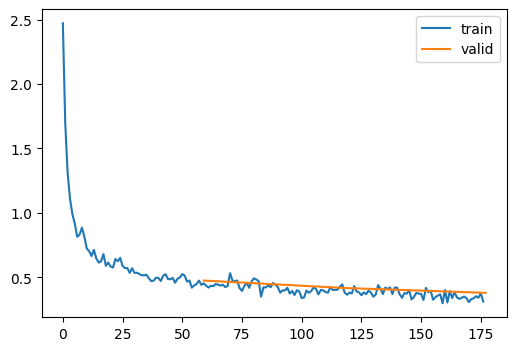

In [33]:
learn.fit(3)

### Momentum

In [34]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs / 3)**2 + torch.randn(100) * 0.1

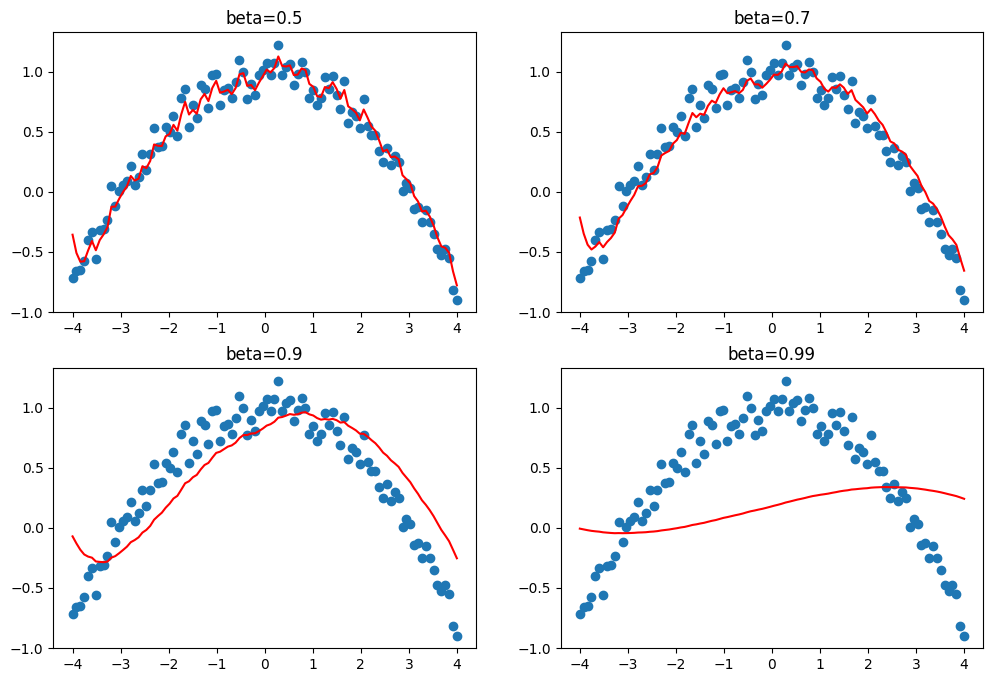

In [35]:
_, axs = plt.subplots(2, 2, figsize=(12, 8))
betas = [0.5, 0.7, 0.9, 0.99]
for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(xs, ys)
    avg, res = 0, []
    for yi in ys:
        avg = beta * avg + (1 - beta) * yi
        res.append(avg)
    ax.plot(xs, np.array(res), color='red')
    ax.set_title(f'{beta=}')

In [36]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'):
            p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg * self.mom + p.grad * (1 - self.mom)
        p -= self.lr * p.grad_avg

In [37]:
set_seed(69)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.786,0.597,0,train
0.854,0.403,0,eval
0.874,0.349,1,train
0.869,0.365,1,eval
0.889,0.305,2,train
0.869,0.351,2,eval


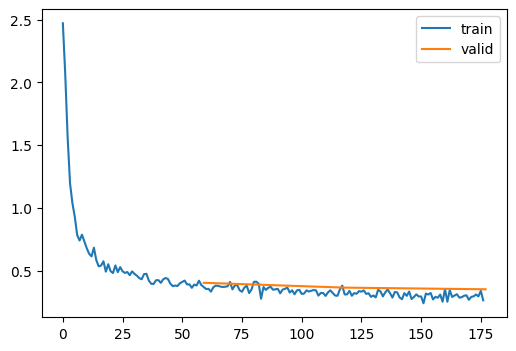

In [38]:
learn.fit(3)

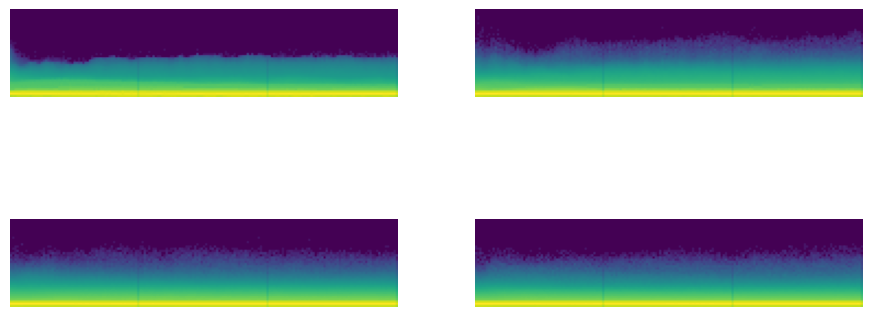

In [39]:
astats.color_dim()

### RMSProp

RMSProp (Root Mean Squared Propagation) Algorithm

On iteration t:
- Compute dW, db on current mini-batch.
- $$ S_{dW} = \beta S_{dW} + (1 - \beta)dW^2 $$
- $$ S_{db} = \beta S_{db} + (1 - \beta)db^2 $$
- $$ W := W - \alpha \frac{dW}{\sqrt{S_{dW}} + \epsilon } $$
- $$ b := b - \alpha \frac{db}{\sqrt{S_{db}} + \epsilon }$$

In [40]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg * self.sqr_mom + p.grad**2 * (1 - self.sqr_mom)
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

- if `p` does not have the attribute `sqr_avg`, initialize it as `p.grad**2`.
- update `p.sqr_avg` by calculating the exponentialy weighted moving average of the sqaured gradients.
- `sqr_mo` is the squared momentum coefficient, controlling the contribution of historical squared gradients.
- update `p` using RMSProp update rule:
$$ p := p - \alpha. \frac{dp}{\sqrt{S_{dp}} + \epsilon} $$
- The division by sqrt of the exponentially weighted moving average of sqaured gradients scales the learning rate for each parameter based on the estimated magnitude of the gradients.

accuracy,loss,epoch,train
0.772,0.656,0,train
0.830,0.456,0,eval
0.853,0.405,1,train
0.854,0.403,1,eval
0.870,0.357,2,train
0.843,0.415,2,eval


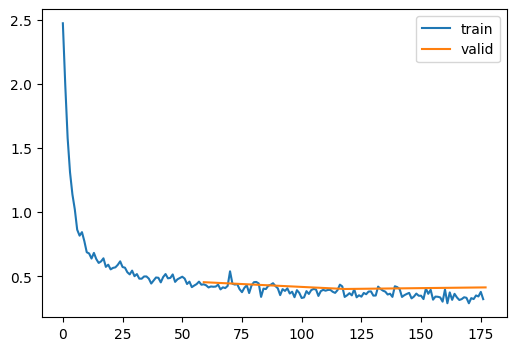

In [41]:
set_seed(69)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

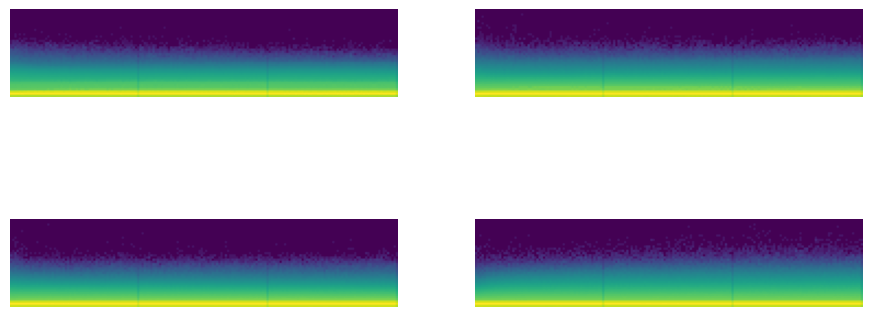

In [42]:
astats.color_dim()

### Adam

Adam Algorithm
- $$V_{dw}=0, S_{dw}=0, V_{db}=0, S_{db}=0$$
- On iteration t:
    - Compute dW, db using current mini-batch
    - `(Momentum)` $$V_{dw}=\beta_1 V_{dw} + (1 - \beta_1)dW, V_{db} - \beta_1V_{db} + (1 - \beta_1)db$$
    - `(RMSProp)` $$S_{dw}=\beta_2 S_{dw} + (1 - \beta_2)dW^2, S_{db} - \beta_2S_{db} + (1 - \beta_2)db^2$$
    - $$ V_{dW}^{corrected} = \frac{V_{dW}}{(1-\beta_1^t)}, V_{db}^{corrected} = \frac{V_{db}}{(1-\beta_1^t)} $$
    - $$ S_{dW}^{corrected} = \frac{S_{dW}}{(1-\beta_2^t)}, S_{db}^{corrected} = \frac{S_{db}}{(1-\beta_2^t)} $$
    - $$ W := W - \alpha  \frac{V_{dW}^{corrected}}{\sqrt{S_{dW}^{corrected}} + \epsilon} , b := b - \alpha  \frac {V^{corrected}_{db}}{\sqrt{S^{corrected}_{db}} + \epsilon}$$

In [43]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.790,0.589,0,train
0.850,0.407,0,eval
0.868,0.362,1,train
0.869,0.361,1,eval
0.888,0.309,2,train
0.871,0.342,2,eval


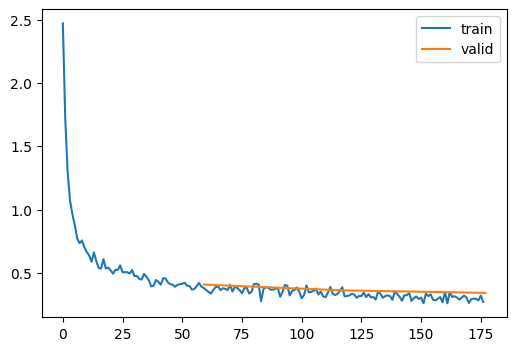

In [44]:
set_seed(69)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

## Schedulers

In [45]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [46]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [49]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [50]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [51]:
param = next(iter(learn.model.parameters()))

In [52]:
st = opt.state[param]

In [54]:
st

{'momentum_buffer': None}

In [53]:
len(opt.param_groups)

1

In [55]:
pg = opt.param_groups[0]
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [56]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [57]:
sched.base_lrs

[0.006]

In [58]:
sched.get_last_lr()

[0.006]

In [59]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

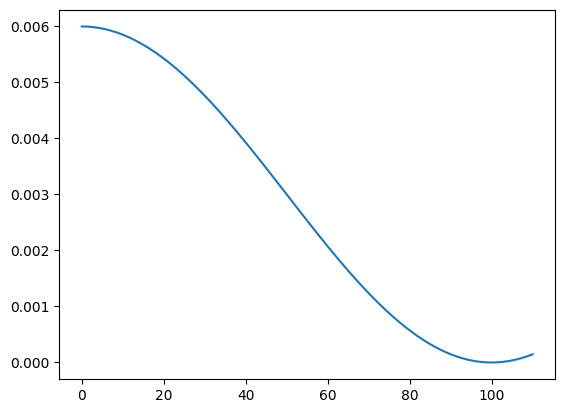

In [60]:
sched_lrs(sched, 110)

### Scheduler Callbacks

In [79]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [80]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [81]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn
    def after_fit(self, learn): self.learn = None

In [82]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]

    def after_batch(self, learn):
        if not learn.training: return
        for k, v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [83]:
def _lr(cb): return cb.pg['lr']

In [84]:
len(dls.train)

59

In [85]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.808,0.530,0,train
0.859,0.379,0,eval
0.882,0.322,1,train
0.878,0.330,1,eval
0.901,0.273,2,train
0.885,0.317,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


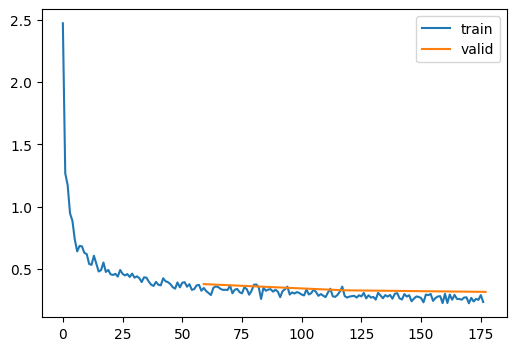

In [86]:
set_seed(69)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.Adam)
learn.fit(3)

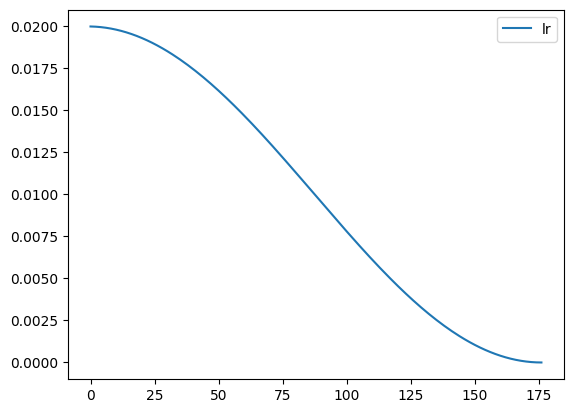

In [87]:
rec.plot()

In [88]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.807,0.531,0,train
0.862,0.381,0,eval
0.881,0.323,1,train
0.874,0.350,1,eval
0.902,0.269,2,train
0.885,0.310,2,eval


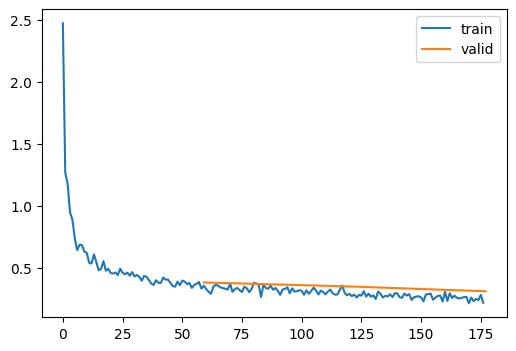

In [89]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(69)
xtra = [EpochSchedCB(sched), rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.Adam)
learn.fit(3)

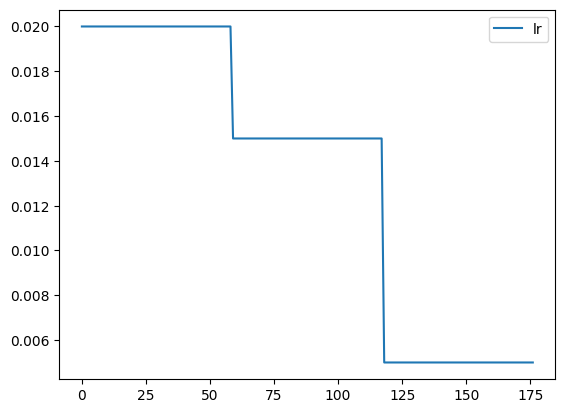

In [90]:
rec.plot()

### 1Cycle Training

- key idea is to start with a low LR, gradually increase it to a higher value and then decrease it again towards the end of the training.
- helps in faster convergence, better generalisation and potentially finding better minimum.
- 1cycle training strategy consists of 3 phases:
    1. Warm-up Phase
        - the LR is gradually increased from a lower initial value to a higher max value.
        - warm-up phase helps the model to quickly converge to a good solution by allowing it to explore a larger portion of the parameter space.
    2. Annealing Phase
        - after reaching the max LR, annealing phase begins.
        - In this phase, the LR is gradually decreased towards the end of training.
        - This reduction in LR helps the model to fine-tune and emerge to a better solution.
    3. Cooldown Phase
        - In this phase, the LR is further reduced to a very small value.
        - This helps the model to stabilize and consolidate its learning towards the end of training.

In [91]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.769,0.659,0,train
0.844,0.478,0,eval
0.863,0.375,1,train
0.873,0.344,1,eval
0.890,0.298,2,train
0.884,0.323,2,eval
0.910,0.244,3,train
0.898,0.278,3,eval
0.924,0.204,4,train
0.906,0.266,4,eval


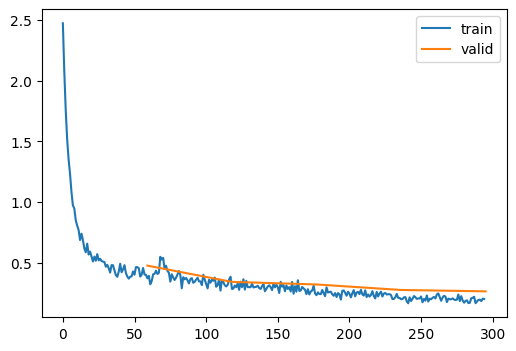

In [92]:
set_seed(69)
lr, epochs = 6e-2, 5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.Adam)
learn.fit(epochs)

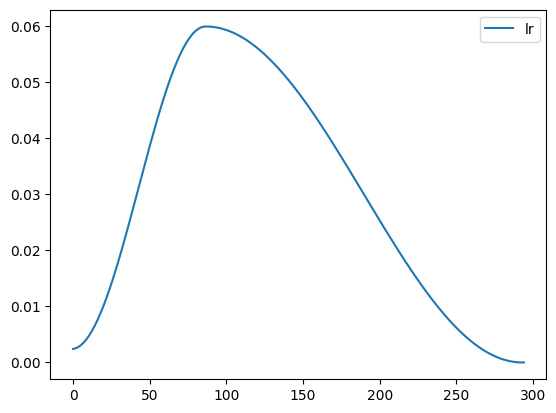

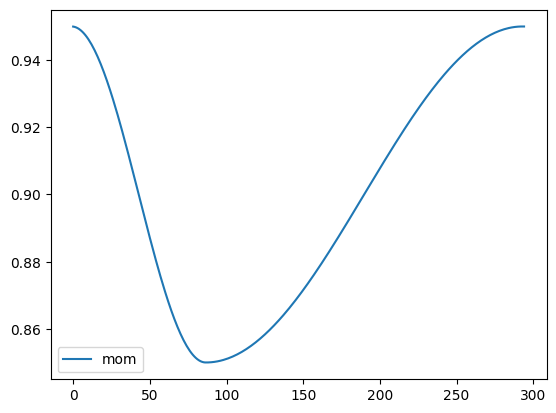

In [93]:
rec.plot()

# Export -

In [2]:
import nbdev
nbdev.nbdev_export()

InterpolationMissingOptionError: Bad value substitution: option 'git_url' in section 'DEFAULT' contains an interpolation key 'user' which is not a valid option name. Raw value: 'https://github.com/%(user)s/%(repo)s'